# 二項P値関数達について

* 黒木玄
* 2025-12-29

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#離散確率分布モデルでの確率の比較で-≤-を使うのは危険" data-toc-modified-id="離散確率分布モデルでの確率の比較で-≤-を使うのは危険-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>離散確率分布モデルでの確率の比較で <code>≤</code> を使うのは危険</a></span></li><li><span><a href="#よく使われる4種の両側P値関数達" data-toc-modified-id="よく使われる4種の両側P値関数達-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>よく使われる4種の両側P値関数達</a></span></li></ul></div>

In [1]:
using Distributions
using StatsPlots
default(fmt=:png)

pgfplotsx(legend_font_halign=:left)
PGFPlotsX.CUSTOM_PREAMBLE = [raw"\usepackage{luatexja}"]
@eval Plots pgfx_sanitize_string(s::AbstractString) = s

pgfx_sanitize_string (generic function with 3 methods)

## 離散確率分布モデルでの確率の比較で `≤` を使うのは危険

In [2]:
# https://x.com/Nmatician/status/2004753008798957797
# https://github.com/enunun/introductiontostatistics/blob/main/src/julia/p-value-function.jl
# x ≤ y を使うのは誤り。
# 代わりに x ⪅ y = x ≤ y || x ≈ y を使うべき。

function p_value_two_sided(dist::Binomial, k)
    n = ntrials(dist)
    prob = pdf(dist, k)
    sum(pdf(dist, i) for i in 0:n if pdf(dist, i) ≤ prob; init=0.0)
end

p_value_two_sided (generic function with 1 method)

$\newcommand\op{\operatorname}
\newcommand\Binomial{\op{Binomial}}
\newcommand\OR{\op{OR}}
\OR = \dfrac{p}{1-p}$ とおくと、

$$
P(i) := \binom{n}{i} p^i (1-p)^{n-i} = (1-p)^n\binom{n}{i} \OR^i, \quad
p = \frac{\OR}{1 + \OR}
$$

でかつ

$$
P(n-2) = P(1) \iff
\frac{n(n-1)}{2} OR^{n-2} = n \OR \iff
\OR = \left(\frac{2}{n-1}\right)^{1/(n-3)}.
$$

浮動小数点数による計算では、この条件を満たしているように見える場合であっても、ぴったり $P(n-2)=P(1)$ となるとは限らない。

In [3]:
function bindist(n)
    OR = (2/(n-1))^(1/(n-3))
    p = OR / (1 + OR)
    Binomial(n, p)
end

bindist (generic function with 1 method)

In [4]:
n = 6
@show bin = bindist(n)
[pdf(bin, i) for i in 0:n]

bin = bindist(n) = Binomial{Float64}(n=6, p=0.42423055457792574)


7-element Vector{Float64}:
 0.03643272751728761
 0.161063178906084
 0.29668091218058273
 0.2914618201383013
 0.16106317890608404
 0.04746894594889324
 0.005829236402766022

In [5]:
@show pdf(bin, 1);
@show pdf(bin, n-2);

pdf(bin, 1) = 0.161063178906084
pdf(bin, n - 2) = 0.16106317890608404


このことが原因で `p_value_two_sided(bin, 1)` と `p_value_two_sided(bin, n-2)` には大きな違いが生じてしまう。

In [6]:
@show p_value_two_sided(bin, 1);
@show p_value_two_sided(bin, n-2);

p_value_two_sided(bin, 1) = 0.25079408877503084
p_value_two_sided(bin, n - 2) = 0.41185726768111486


以下のような改訂が必要である。

In [7]:
x ⪅ y = x ≤ y || x ≈ y

function p_value_two_sided_revised(dist::Binomial, k)
    n = ntrials(dist)
    prob = pdf(dist, k)
    sum(pdf(dist, i) for i in 0:n if pdf(dist, i) ⪅ prob; init=0.0)
end

p_value_two_sided_revised (generic function with 1 method)

変更点は `≤` を `⪅` で置き換えただけである。

In [8]:
@show p_value_two_sided_revised(bin, 1);
@show p_value_two_sided_revised(bin, n-2);

p_value_two_sided_revised(bin, 1) = 0.41185726768111486
p_value_two_sided_revised(bin, n - 2) = 0.41185726768111486


このようにそれだけの変更で正しい答えが得られるようになる。

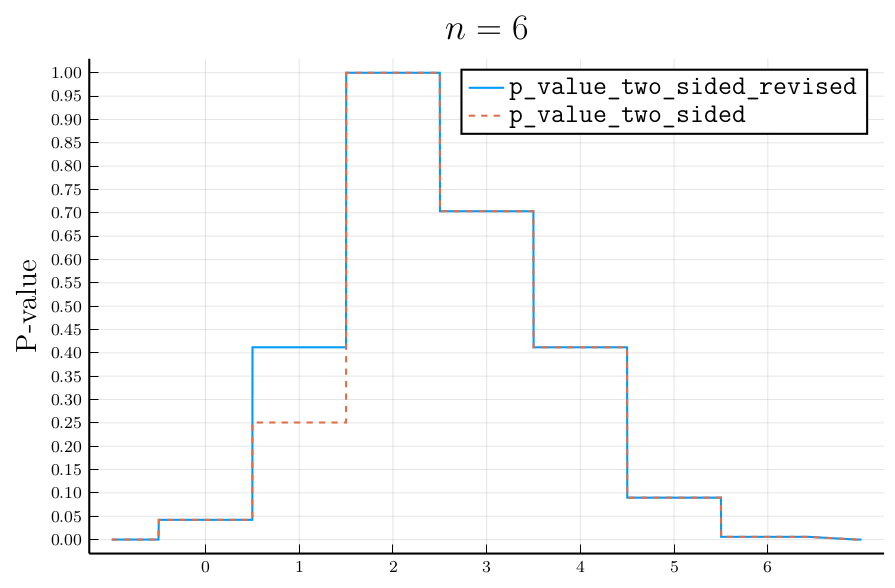

In [9]:
n = 6
bin = bindist(n)
plot(k -> p_value_two_sided_revised(bin, round(Int, k)), -1, n+1;
    label="\\texttt{p\\_value\\_two\\_sided\\_revised}")
plot!(k -> p_value_two_sided(bin, round(Int, k)), -1, n+1;
    label="\\texttt{p\\_value\\_two\\_sided}", ls=:dash)
plot!(xtick=0:n, ytick=0:0.05:1, yguide="P-value", legend=:topright)
plot!(legendfontsize=13, guidefontsize=14, titlefontsize=18)
title!("\$n = $n\$")

In [10]:
function f(n)
    OR = (2/(n-1))^(1/(n-3))
    p = OR / (1 + OR)
    bin = Binomial(n, p)
    pdf(bin, 1) != pdf(bin, n-2)
end

@show [n for n in 1:30 if f(n)];

[n for n = 1:30 if f(n)] = [5, 6, 7, 8, 9, 11, 13, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29]


このように多くの場合にぴったり $P(n-2)=P(1)$ とはならない。

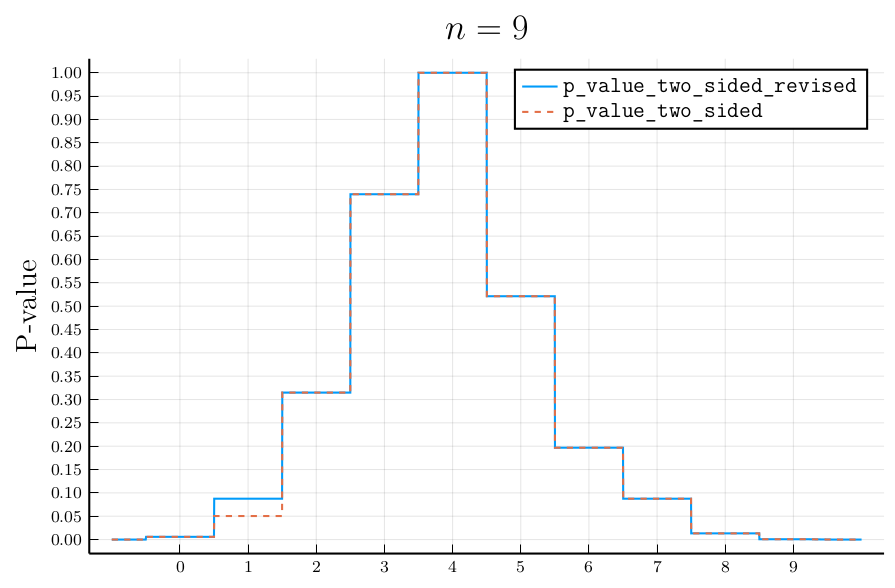

In [11]:
n = 9
bin = bindist(n)
plot(k -> p_value_two_sided_revised(bin, round(Int, k)), -1, n+1;
    label="\\texttt{p\\_value\\_two\\_sided\\_revised}")
plot!(k -> p_value_two_sided(bin, round(Int, k)), -1, n+1;
    label="\\texttt{p\\_value\\_two\\_sided}", ls=:dash)
plot!(xtick=0:n, ytick=0:0.05:1, yguide="P-value", legend=:topright)
plot!(legendfontsize=11, guidefontsize=14, titlefontsize=18)
title!("\$n = $n\$")

## よく使われる4種の両側P値関数達

In [12]:
x ⪅ y = x ≤ y || x ≈ y

function pvalue_minlike(k, n, p)
    bin = Binomial(n, p)
    prob = pdf(bin, k)
    sum(pdf(bin, i) for i in support(bin) if pdf(bin, i) ⪅ prob; init=zero(prob))
end

function pvalue_central(k, n, p)
    bin = Binomial(n, p)
    min(1, 2cdf(bin, k), 2ccdf(bin, k-1))
end

function pvalue_score(k, n, p)
    phat = k / n
    se = sqrt(p * (1 - p) / n)
    z = (phat - p) / se
    2ccdf(Normal(), abs(z))
end

function pvalue_wald(k, n, p)
    phat = k / n
    sehat = sqrt(phat * (1 - phat) / n)
    z = (phat - p) / sehat
    2ccdf(Normal(), abs(z))
end

pvalue_wald (generic function with 1 method)

In [13]:
function plot_pvalue_functions(k, n)
    plot()
    plot!(p -> pvalue_central(k, n, p), 0, 1; label="中心法", ls=:solid)
    plot!(p -> pvalue_minlike(k, n, p), 0, 1; label="最小尤度法", ls=:dash)
    plot!(p -> pvalue_score(k, n, p), 0, 1; label="スコア法", ls=:solid)
    plot!(p -> pvalue_wald(k, n, p), 0, 1; label="Wald法", ls=:dashdot)
    plot!(xtick=0:0.1:1, ytick=0:0.05:1)
    plot!(xguide="成功確率の仮説値", yguide="P値=仮説値とデータの値の相性の良さ")
    plot!(legend=:topright)
    plot!(legendfontsize=13, guidefontsize=14, titlefontsize=18)
    title!("データの値: \$n = $n\$ 回中 \$k = $k\$ 成功")
end

plot_pvalue_functions (generic function with 1 method)

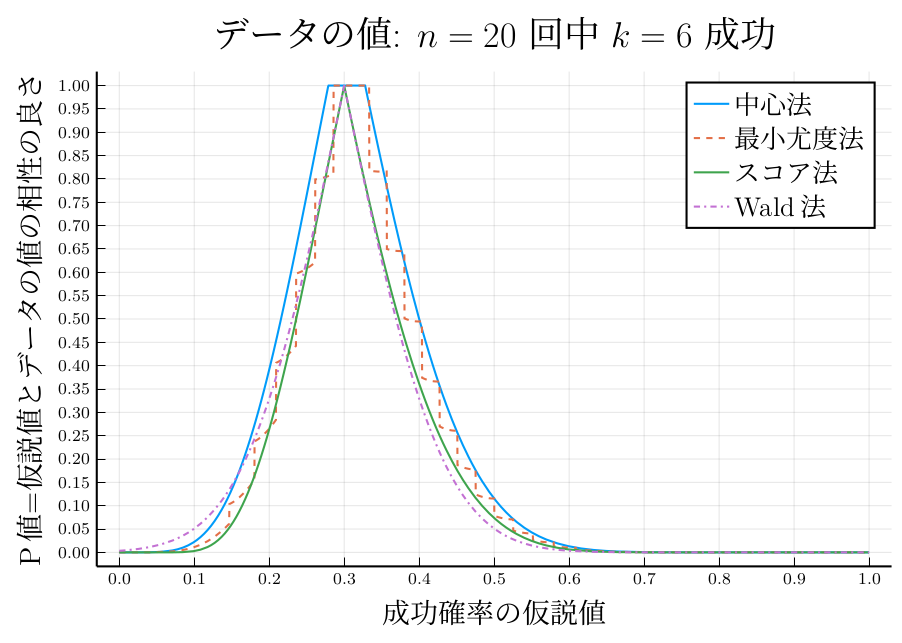

In [14]:
plot_pvalue_functions(6, 20)

中心法(central method)は最も保守的(P値が大きくなり易い)なので、保守的であることが利点になる場合に使うと良い。

最小尤度法(minimum likelihood method)はαエラー率を有意水準α以下に保ったまま、中心法での行き過ぎた保守性を緩和している。しかし、P値関数が連続でも単峰型でもなくなるという欠点があり、対応する信頼区間の計算も面倒になる。

スコア法は二項分布の正規分布近似に基く最も自然な両側P値関数を与える。 [Agresti-Coull 1998](https://scholar.google.co.jp/scholar?cluster=5129299358902170657) によれば、この方法は優れた性質を持つ。ただし、この方法ではαエラー率が有意水準αを少し上回る場合で出て来る。

Wald法は精度的にスコア法の劣化版になっている。精度劣化の原因は推定しなくてもよい標準偏差を推定してしまっているからである。この方法では対応する信頼区間の計算が非常に易しくなる。

これら4種の方法はどれも異なる利点と欠点を持っており、どれか1つが他よりもあらゆる面で優れているわけではない。

以下のグラフを見れば、サンプルサイズ $n$ を十分に大きくすれば(より正確には $\min(np, n(1-p))$ を十分に大きくすれば)、どれを使っても大差ないことがわかる。

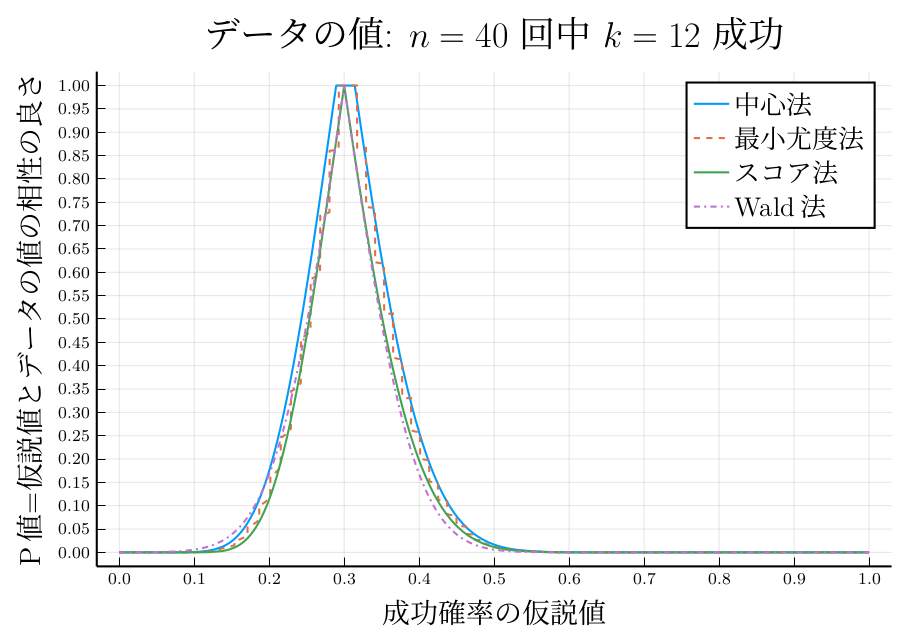

In [15]:
plot_pvalue_functions(12, 40)

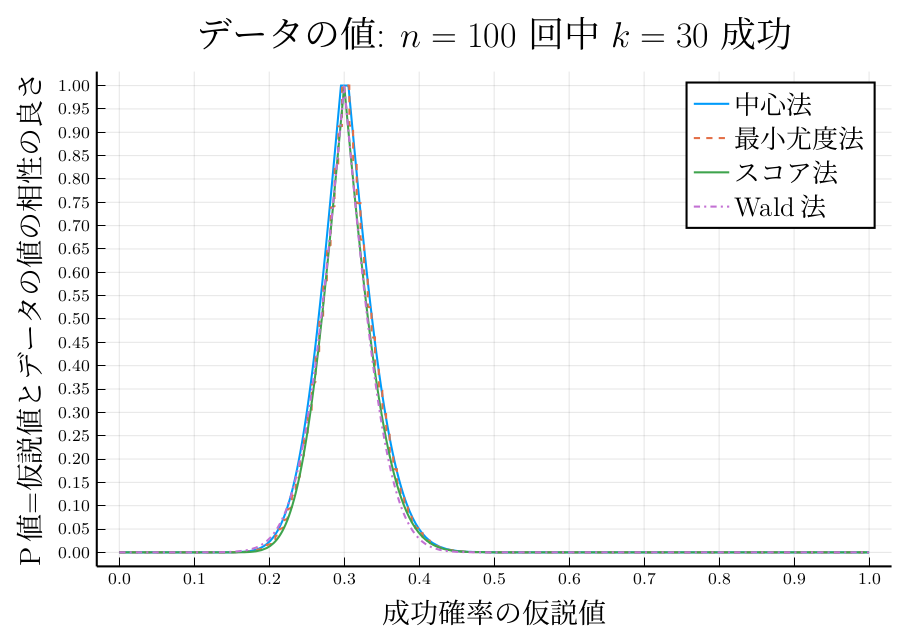

In [16]:
plot_pvalue_functions(30, 100)

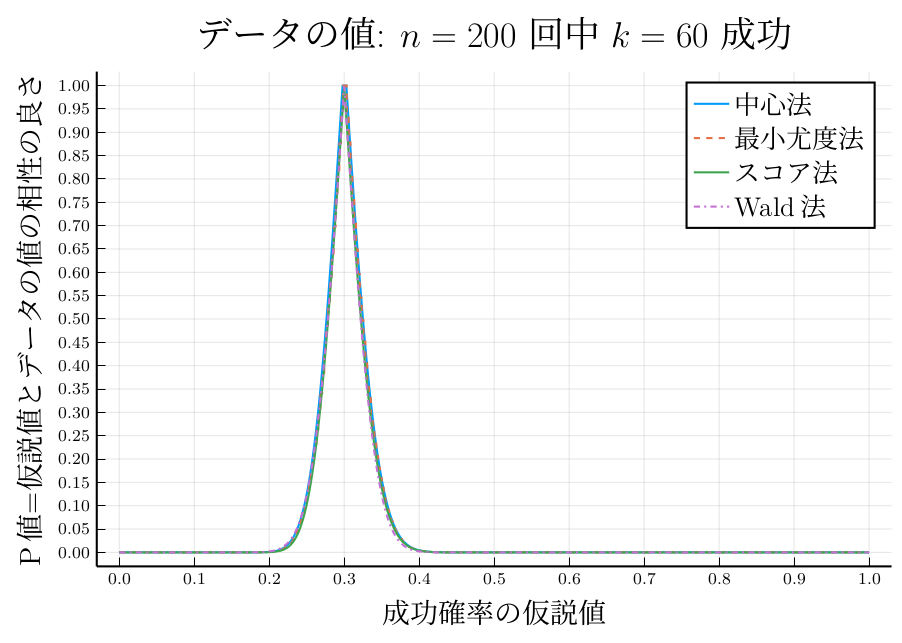

In [17]:
plot_pvalue_functions(60, 200)